# Optimal Frenet Path Planning

In [12]:
import numpy as np

In [13]:
# Way points
way_points_x = [00.0, 20.0, 30.0, 50.0]
way_points_y = [00.0, 00.75, 2.15, 03.0]


way_points_x = [00.0, 20.0, 30.0, 50.0];
way_points_y = [00.0, 00.5, 04.5, 07.0];

In [14]:
## Define Obstacles

In [46]:
objects = np.array([[10.0, -0.5],
           [15.0, 2.0],
           [20.0, 0.0],
           [30.0, 3.0],
           [45.0, 3.5]])

In [47]:
objects

array([[10. , -0.5],
       [15. ,  2. ],
       [20. ,  0. ],
       [30. ,  3. ],
       [45. ,  3.5]])

In [48]:
## Create a reference path

In [49]:
import cubic_spline_planner as csp

def calc_spline_course(x, y, ds=0.1):
    sp = csp.CubicSpline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))
    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))
    return rx, ry, ryaw, rk, s

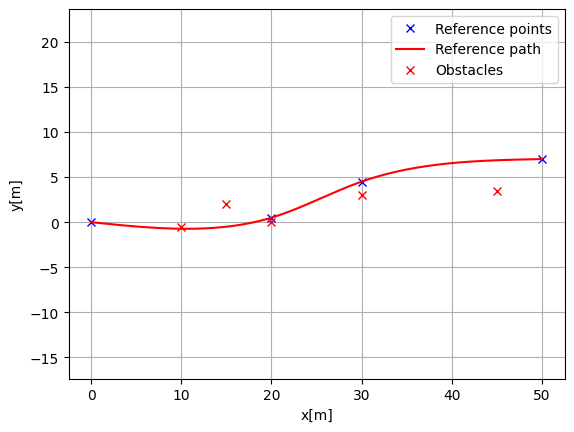

In [50]:
ref_path_x, ref_path_y, ref_path_yaw, ref_path_k, ref_path_s = calc_spline_course(way_points_x, way_points_y)

## Plot the reference path
import matplotlib.pyplot as plt
 
plt.subplots(1)
plt.plot(way_points_x, way_points_y, "xb", label="Reference points")
plt.plot(ref_path_x, ref_path_y, "-r", label="Reference path")
plt.plot(objects[:,0], objects[:,1], "xr", label="Obstacles")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()



In [51]:
# lambda function for object bounding box
obj_bbox = lambda ox, oy: np.array([[ox-1, oy+1],
        [ox-1, oy+0.5],
        [ox-1, oy],
        [ox-1, oy-0.5],
        [ox-1, oy-1],
        [ox, oy-1],
        [ox+1, oy-1],
        [ox+2, oy-1],
        [ox+3, oy-1],
        [ox+3, oy-0.5],
        [ox+3, oy],
        [ox+3, oy+0.5],
        [ox+3, oy+1],
        [ox+2, oy+1],
        [ox+1, oy+1],
        [ox, oy+1],
        [ox-1, oy+1]])

In [52]:
obj_bbox(10, 0)

array([[ 9. ,  1. ],
       [ 9. ,  0.5],
       [ 9. ,  0. ],
       [ 9. , -0.5],
       [ 9. , -1. ],
       [10. , -1. ],
       [11. , -1. ],
       [12. , -1. ],
       [13. , -1. ],
       [13. , -0.5],
       [13. ,  0. ],
       [13. ,  0.5],
       [13. ,  1. ],
       [12. ,  1. ],
       [11. ,  1. ],
       [10. ,  1. ],
       [ 9. ,  1. ]])

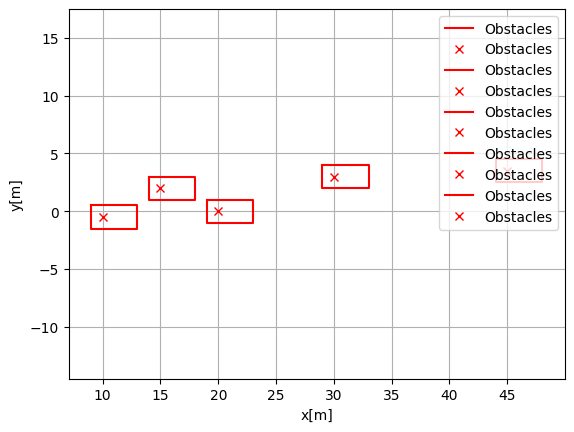

In [53]:
for i in range(len(objects)):
    obj_x, obj_y = objects[i,0], objects[i,1]
    plt.plot(obj_bbox(obj_x, obj_y)[:,0], obj_bbox(obj_x, obj_y)[:,1], "-r", label="Obstacles")
    plt.plot(obj_x, obj_y, "xr", label="Obstacles")

plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()


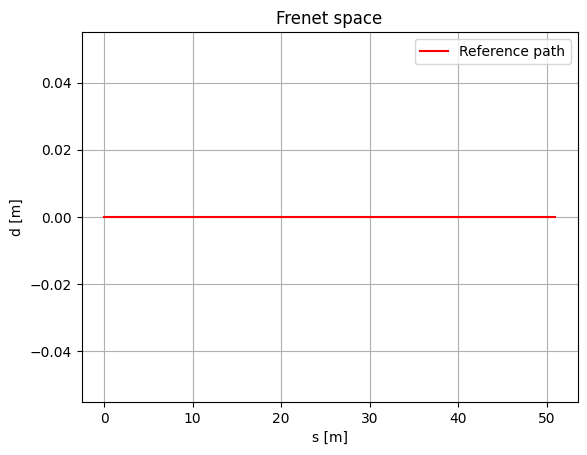

In [23]:
# Plot frenet space
plt.subplots(1)
ref_path_run_length = ref_path_s[-1]
plt.plot([0, ref_path_run_length], [0, 0], "-r", label="Reference path")
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("d [m]")
plt.title("Frenet space")
plt.legend()


In [24]:
# TODO delete
def calc_global_paths(fplist, csp):

    for fp in fplist:

        # calc global positions
        for i in range(len(fp.s)):
            ix, iy = csp.calc_position(fp.s[i])
            if ix is None:
                break
            iyaw = csp.calc_yaw(fp.s[i])
            di = fp.d[i]
            fx = ix + di * math.cos(iyaw + math.pi / 2.0)
            fy = iy + di * math.sin(iyaw + math.pi / 2.0)
            fp.x.append(fx)
            fp.y.append(fy)

        # calc yaw and ds
        for i in range(len(fp.x) - 1):
            dx = fp.x[i + 1] - fp.x[i]
            dy = fp.y[i + 1] - fp.y[i]
            fp.yaw.append(math.atan2(dy, dx))
            fp.ds.append(math.sqrt(dx**2 + dy**2))

        fp.yaw.append(fp.yaw[-1])
        fp.ds.append(fp.ds[-1])

        # calc curvature
        for i in range(len(fp.yaw) - 1):
            fp.c.append((fp.yaw[i + 1] - fp.yaw[i]) / fp.ds[i])

    return fplist

In [25]:
import numpy as np

def distance(x0, y0, x1, y1):
    return np.sqrt((x0 - x1)**2 + (y0 - y1)**2)

In [26]:
# TODO Delete
def cartesian_to_frenet(x, y, yaw, rx, ry):
    # Shift to local coordinate
    shift_x = [ix - x for ix in rx]
    shift_y = [iy - y for iy in ry]

    # Rotate to local coordinate
    shift_yaw = [iyaw - yaw for iyaw in ryaw]

    # Calculate frenet coordinate
    shift_s = [0.0]
    shift_d = [0.0]
    for i in range(len(shift_x)-1):
        shift_s.append(shift_s[i] + np.hypot(shift_x[i+1], shift_y[i+1]))
        shift_d.append(np.cross([shift_x[i], shift_y[i]], [np.cos(shift_yaw[i]), np.sin(shift_yaw[i])]))

    return shift_s, shift_d

def _closest_ref_points(x, y, ref_path_x, ref_path_y):
    closest_dist = float("inf")
    closest_ref_point_idx = 0

    for i in range(len(ref_path_x)):
        ref_x = ref_path_x[i]
        ref_y = ref_path_y[i]

        dist = distance(x, y, ref_x, ref_y)

        if dist < closest_dist:
            closest_dist = dist
            closest_ref_point_idx = i
        else:
            break

    # Define 2nd closes ref point index
    # Handle edge cases
    if closest_ref_point_idx == len(ref_path_x):
        closest_2nd_ref_point_idx = closest_ref_point_idx - 1
    elif closest_ref_point_idx == 1:
        closest_2nd_ref_point_idx = closest_ref_point_idx + 1
    else: # Handle default case
        ref_x_p1 = ref_path_x[closest_ref_point_idx + 1]
        ref_y_p1 = ref_path_y[closest_ref_point_idx + 1]
        dist_p1 = distance(x, y, ref_x_p1, ref_y_p1)

        ref_x_m1 = ref_path_x[closest_ref_point_idx - 1]
        ref_y_m1 = ref_path_y[closest_ref_point_idx - 1]
        dist_m1 = distance(x, y, ref_x_m1, ref_y_m1)

        if dist_p1 < dist_m1:
            closest_2nd_ref_point_idx = closest_ref_point_idx + 1
        else:
            closest_2nd_ref_point_idx = closest_ref_point_idx - 1

    return closest_ref_point_idx, closest_2nd_ref_point_idx


def cartesian_to_frenet(x, y, yaw, ref_path_x, ref_path_y):
    # Find closest ref points
    closest_ref_point_idx, closest_2nd_ref_point_idx = _closest_ref_points(x, y, ref_path_x, ref_path_y)

    if closest_ref_point_idx > closest_2nd_ref_point_idx:
        next_ref_point_idx = closest_ref_point_idx
    else:
        next_ref_point_idx = closest_2nd_ref_point_idx

    prev_ref_point_idx = next_ref_point_idx - 1
    if next_ref_point_idx == 0:
        prev_ref_point_idx = 0
        next_ref_point_idx = 1

    tangent_x = ref_path_x[next_ref_point_idx] - ref_path_x[prev_ref_point_idx]
    tangent_y = ref_path_y[next_ref_point_idx] - ref_path_y[prev_ref_point_idx]

    #qTangent = quiver(RefX(nPrevRefPoint), RefY(nPrevRefPoint), fTangentX, fTangentY, 0);

    vec_x = x - ref_path_x[prev_ref_point_idx]
    vec_y = y - ref_path_y[prev_ref_point_idx]

    #qVec = quiver(RefX(nPrevRefPoint), RefY(nPrevRefPoint), fVecX, fVecY, 0);
    
    # Find the projection of vec onto tangential vector
    #projected_vec_norm = (vec_x * tangent_x + vec_y * tangent_y) / (tangent_x * tangent_x + tangent_y * tangent_y)
    #projected_vec_norm = (vec_x * tangent_x + vec_y * tangent_y) / math.sqrt(tangent_x * tangent_x + tangent_y * tangent_y)

    tangent_length = math.sqrt(tangent_x * tangent_x + tangent_y * tangent_y)
    projected_vec_norm =  np.dot([vec_x, vec_y], [tangent_x, tangent_y]) / tangent_length

    projected_vec_x = projected_vec_norm * tangent_x / tangent_length
    projected_vec_y = projected_vec_norm * tangent_y / tangent_length


    #qProjectedVec = quiver(RefX(nPrevRefPoint), RefY(nPrevRefPoint), fProjectedVecX, fProjectedVecY, 0);

    # Calculate frenet coordinate
    #frenet_d = np.cross([vec_x, vec_y], [tangent_x, tangent_y]) / tangent_length

    frenet_d = distance(vec_x, vec_y, projected_vec_x, projected_vec_y)

    # Check if d value is positive or negative using the dot product result
    x0 = ref_path_x[prev_ref_point_idx]
    y0 = ref_path_y[prev_ref_point_idx]
    x1 = ref_path_x[next_ref_point_idx]
    y1 = ref_path_y[next_ref_point_idx]

    # why negative?
    d = (x - x0) * (y1 - y0) - (y - y0) * (x1 - x0)
    d2 = np.dot([x - x0, y - y0], [y1 - y0, -(x1 - x0)])

    side = np.sign(d)
    side2 = np.sign(d2)

    if side > 0:
        frenet_d = -frenet_d


    # Calculate frenet s coordinate
    frenet_s = 0
    for i in range(prev_ref_point_idx):
        frenet_s += distance(ref_path_x[i], ref_path_y[i], ref_path_x[i+1], ref_path_y[i+1])

    frenet_s2 = frenet_s    
    frenet_s += projected_vec_norm
    frenet_s2 = distance(0, 0, projected_vec_x, projected_vec_y)

    return frenet_s, frenet_d


(0.0, 0.0)

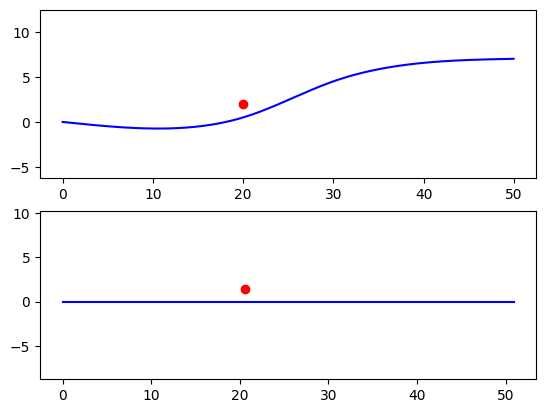

In [39]:
x = 20
y = 2
frenet_s, frenet_d = cartesian_to_frenet(x, y, 0, ref_path_x, ref_path_y)

# subplots for cartesian and frenet coordinates
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ref_path_x, ref_path_y, 'b-')
ax1.plot(x, y, 'ro')
ax1.axis('equal')

ref_path_run_length = ref_path_s[-1]
ref_path_s = [0, ref_path_run_length]
ref_path_d = [0, 0]
ax2.plot(ref_path_s, ref_path_d, 'b-', label='Reference path')
ax2.plot(frenet_s, frenet_d, 'ro')
ax2.axis('equal')
plt.show()

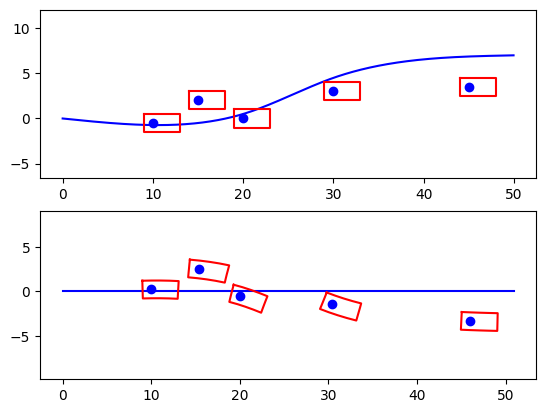

In [55]:
# Plot objects including bounding boxes
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ref_path_x, ref_path_y, 'b-')
ax1.axis('equal')

ref_path_run_length = ref_path_s[-1]
ref_path_s = [0, ref_path_run_length]
ref_path_d = [0, 0]
ax2.plot(ref_path_s, ref_path_d, 'b-', label='Reference path')
ax2.axis('equal')

objects = np.array([[10.0, -0.5],
           [15.0, 2.0],
           [20.0, 0.0],
           [30.0, 3.0],
           [45.0, 3.5]])


for i in range(len(objects)):
    obj = objects[i]
    obj_x = obj[0]
    obj_y = obj[1]
    obj_s, obj_d = cartesian_to_frenet(obj_x, obj_y, 0, ref_path_x, ref_path_y)

    ax1.plot(obj_x, obj_y, 'bo')
    ax2.plot(obj_s, obj_d, 'bo')

    # Plot bounding box using obj_bbox
    obj_box = obj_bbox(obj_x, obj_y)

    obj_points = len(obj_box)
    obj_box_s = np.zeros(obj_points)
    obj_box_d = np.zeros(obj_points)
    for j in range(obj_points):
        obj_box_s[j], obj_box_d[j] = cartesian_to_frenet(obj_box[j][0], obj_box[j][1], 0, ref_path_x, ref_path_y)

    ax1.plot(obj_box[:,0], obj_box[:,1], 'r-')
    ax2.plot(obj_box_s, obj_box_d, 'r-')
    
     


In [ ]:
for i = 1:length(faObjects)
    fObjX = faObjects(i,1);
    fObjY = faObjects(i,2);
    
    [fObjS, fObjD] = Cart2FRT(fObjX, fObjY, 0, faRefX, faRefY);
    
    hof = plot(fObjS, fObjD, 'kx', 'DisplayName', 'Objects');
    
    
    faObj = hObj(fObjX, fObjY);

    nObjPoints = size(faObj,1);
    faObjS = zeros(1, nObjPoints);
    faObjD = zeros(1, nObjPoints);
    for j = 1:nObjPoints
        fObjX = faObj(j,1);
        fObjY = faObj(j,2);
    
        [fObjS, fObjD] = Cart2FRT(fObjX, fObjY, 0, faRefX, faRefY);
        faObjS(j) = fObjS;
        faObjD(j) = fObjD;
        
    end
    
    plot(faObjS, faObjD, 'k.-');
    
end

hl = legend([hrf, hof], 'Location', 'best');
set(hl, 'Interpreter', 'latex');

fObjX = faObjects(1,1)
fObjY = faObjects(1,2)

[fObjS, fObjD] = Cart2FRT(fObjX, fObjY, 0, faRefX, faRefY);

[fX, fY] = FRT2Cart(fObjS, fObjD, faRefRunLength, faRefX, faRefY)



fObjX == fX
fObjY == fY
